In [3]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

sns.set_theme(style="whitegrid")
sns.set_palette("Set2")

#loading model
def load_model(model_path="models/gbdt_logprice_final.joblib"): #hardcoding best model for now
    try:
        mdl = joblib.load(model_path)
        print(f"Model loaded from {model_path}")
        print("log model used" if mdl['is_log_model'] else "Direct price model used")
        return mdl
    except Exception as e:
        print(f"Error loading model: {e}")
        return None

#predicting price
def predict_price(features_df, model_info):
    #checking feats
    feat_names = model_info['feature_names']
    for ft in feat_names:
        if ft not in features_df.columns:
            print(f"warning: feature {ft} not found in data input...filling with zero")
            features_df[ft] = 0
    
    #making preds
    Xval = features_df[feat_names].values
    initp = model_info['initial_pred']
    trees = model_info['trees']
    lrate = model_info['learning_rate']
    
    def gb_predict(X, pinit, treelist, lr):
        #combining weak learners
        X = np.asarray(X)
        ypred = np.full(X.shape[0], pinit)
        for t in treelist:
            ypred += lr * t.predict(X)
        return ypred
    
    preds = gb_predict(Xval, initp, trees, lrate)
    
    #adjusting for log scale
    if model_info['is_log_model']:
        preds = np.expm1(preds)
    return preds

#engineering features
def engineer_features_for_prediction(games_df):
    df = games_df.copy()
    
    #defining defaults
    def_feats = {
        'reviews_total': 0,
        'achievements': 0,
        'tags': '',
        'genres': '',
        'categories': '',
        'publishers': 'Unknown',
        'developers': 'Unknown',
        'combined_score': 0.5,
        'is_highly_rated': 0,
        'reviews_score_fancy': 0
    }
    for col, val in def_feats.items():
        if col not in df.columns:
            df[col] = val
    
    #creating basic counts
    df['tags_count'] = df['tags'].astype(str).apply(lambda x: len(str(x).split(',')))
    df['genres_count'] = df['genres'].astype(str).apply(lambda x: len(str(x).split(',')))
    df['categories_count'] = df['categories'].astype(str).apply(lambda x: len(str(x).split(',')))
    
    #doing log transforms
    df['reviews_total_log'] = np.log1p(np.maximum(0, df['reviews_total']))
    df['achievements_log'] = np.log1p(np.maximum(0, df['achievements']))
    
    #assigning defaults
    df['is_free_or_cheap'] = 0
    df['stsp_owners_log'] = df['reviews_total_log'] * 2
    df['hltb_single_log'] = 2.0
    df['hltb_complete_log'] = 2.5
    
    tagflags = [
        'indie','action','rpg','strategy','casual','adventure','simulation','multiplayer','early_access',
        'puzzle','story_rich','open_world'
    ]
    #adding binary flags
    for tg in tagflags:
        df[f'tags_has_{tg}'] = df['tags'].str.contains(tg, case=False, na=False).astype(int)
        df[f'genres_has_{tg}'] = df['genres'].str.contains(tg, case=False, na=False).astype(int)
    
    df['publishers_game_count'] = 5
    df['publishers_log_games'] = np.log1p(df['publishers_game_count'])
    
    def check_aaa(x):
        bigcos = [
            'Ubisoft','Electronic Arts','EA','Activision','Blizzard','Square Enix','Capcom','Bethesda','Microsoft','Sony'
        ]
        return 1 if any(c.lower() in x.lower() for c in bigcos) else 0
    df['publishers_is_aaa'] = df['publishers'].apply(check_aaa)
    
    #normalizing scores
    def norm_score(x):
        try:
            return min(1.0, float(str(x).replace('%',''))/100)
        except:
            return 0.5
    df['reviews_score_fancy_norm'] = df['reviews_score_fancy'].apply(norm_score)
    df['has_indie_keywords'] = df['tags'].str.contains('Indie|Small|Casual', case=False, na=False).astype(int)
    
    df['score_x_log_reviews'] = df['combined_score'] * df['reviews_total_log']
    def achclip(x):
        return np.clip(x/100, 0, 1)
    df['quality_indicator'] = (
        df['combined_score'] + 
        achclip(df['achievements']) + 
        np.clip(df['reviews_score_fancy_norm'], 0, 1)
    ) / 3
    
    numcols = df.select_dtypes(include=np.number).columns
    df[numcols] = df[numcols].fillna(0)
    return df

#formating price
def format_price(px):
    return f"${px:.2f}"

def create_price_bucket(px):
    brks = [0,4.99,9.99,14.99,19.99,29.99,39.99,59.99,float('inf')]
    lbls = [
        '$0-$4.99','$5-$9.99','$10-$14.99','$15-$19.99',
        '$20-$29.99','$30-$39.99','$40-$59.99','$60+'
    ]
    for i in range(len(brks)-1):
        if brks[i] <= px <= brks[i+1]:
            return lbls[i]
    return lbls[-1]

#estimating elasticity
def estimate_elasticity(frow):
    base = -1.5
    sc = frow.get('combined_score',0.5)
    aaa = frow.get('publishers_is_aaa',0)
    highrat = frow.get('is_highly_rated',0)
    if highrat:
        base += 0.3
    if aaa:
        base += 0.35
    if frow.get('genres_has_indie',0):
        base -= 0.25
    if frow.get('genres_has_casual',0):
        base -= 0.3
    if frow.get('genres_has_rpg',0):
        base += 0.25
    if frow.get('genres_has_strategy',0):
        base += 0.15
    return max(-3.0, min(-0.2, base))

#recommending discount
def recommend_discount(frow):
    disc = 0.0
    sc = frow.get('combined_score',0.5)
    aaa = frow.get('publishers_is_aaa',0)
    if sc < 0.4:
        disc += 0.15
    elif sc < 0.7:
        disc += 0.15 - (sc - 0.4)*0.33
    else:
        disc += 0.05 - (sc - 0.7)*0.15
    if not aaa:
        disc += 0.05
    if frow.get('genres_has_indie',0):
        disc += 0.05
    if frow.get('genres_has_casual',0):
        disc += 0.05
    if frow.get('genres_has_rpg',0):
        disc -= 0.05
    return min(90, max(0, disc*100))

def simulate_revenue_at_price(price, elasticity=-1.5, base_quantity=100):
    return price*base_quantity

#suggesting optimal price
def suggest_optimal_price(frow, predpx, elast):
    if elast <= -2.0:
        return predpx*0.85
    elif elast <= -1.5:
        return predpx*0.95
    elif elast >= -0.8:
        return predpx*1.15
    elif elast >= -1.0:
        return predpx*1.05
    else:
        return predpx

Model loaded from models/gbdt_logprice_final.joblib
log model used
Model has 200 trees and uses 67 features
first five features: ['reviews_score_fancy_norm', 'is_highly_rated', 'meta_score_norm', 'meta_uscore_norm', 'igdb_score_norm']

--- EXAMPLE 1 SINGLE GAME PREDICTION ---
Game: Epic Adventure
predicted price: $18.28
price bucket: $15-$19.99

--- EXAMPLE 2 GENRE PRICE COMPARISON ---
        Genre Predicted Price Price Bucket
0         RPG          $17.45   $15-$19.99
1      Action          $16.83   $15-$19.99
2    Strategy          $17.21   $15-$19.99
3  Simulation          $19.21   $15-$19.99
4      Casual          $13.50   $10-$14.99
5       Indie          $11.97   $10-$14.99


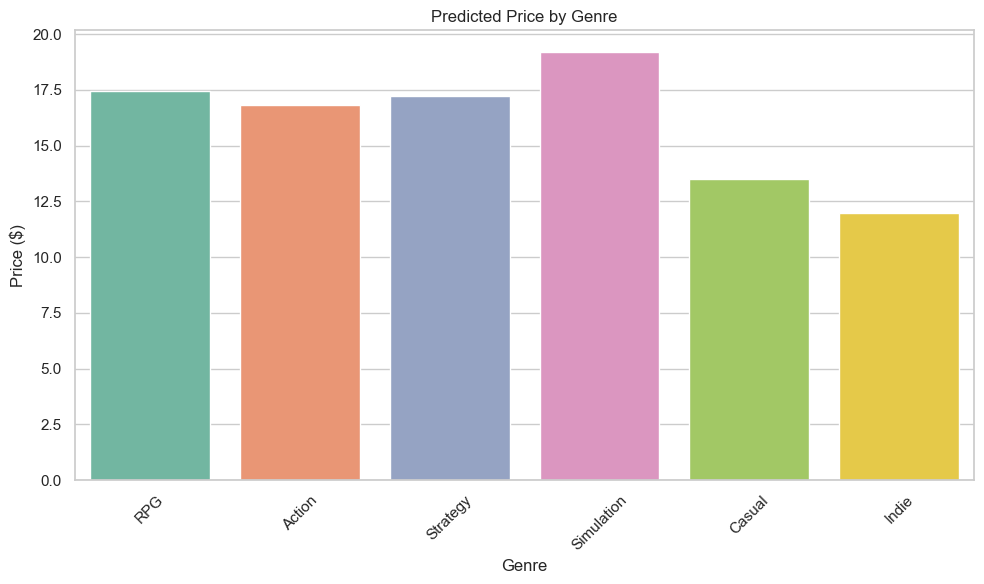


---- EXAMPLE 3 REVIEW SCORE IMPACT ---
   Review Score Predicted Price
0            30          $13.99
1            50          $14.99
2            70          $15.02
3            80          $15.02
4            90          $14.17
5            95          $14.31


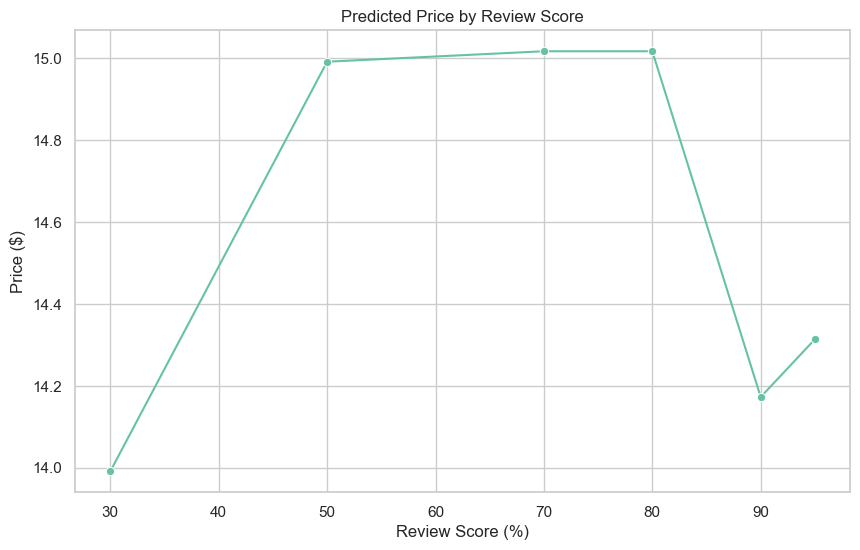


----- EXAMPLE 4 AAA VS INDIE PUBLISHER ----
             Publisher   Type Predicted Price  Elasticity Recommended Discount
0              Ubisoft    AAA          $19.37       -0.85                 3.5%
1      Electronic Arts    AAA          $18.80       -0.85                 2.8%
2  Activision Blizzard    AAA          $18.59       -0.85                 2.0%
3       Indie Studio A  Indie          $16.11       -1.20                 9.2%
4    Small Developer B  Indie          $14.46       -1.50                10.0%
5     Solo Developer C  Indie          $10.56       -1.50                13.4%


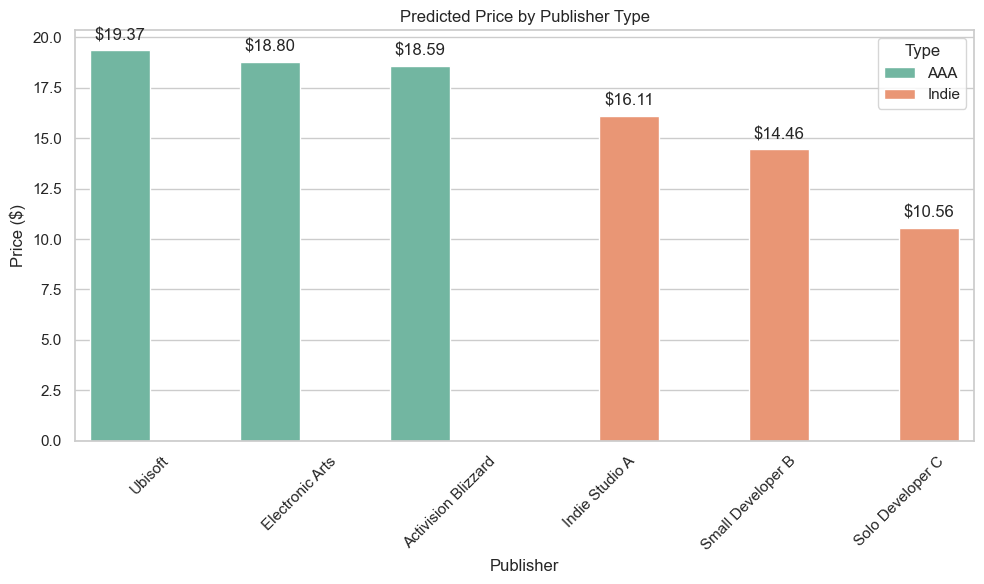


--- EXAMPLE 5 OPTIMAL PRICING STRATEGY ---

Game: Game from Ubisoft
Publisher: Ubisoft (Type: AAA)
Base predicted price: $19.37
Estimated elasticity: -0.85
optimal price adjustment: +5%
optimal price: $20.34
Revenue change vs base: 0.4%
Promotion discount: 3.5%
Sale price: $18.70


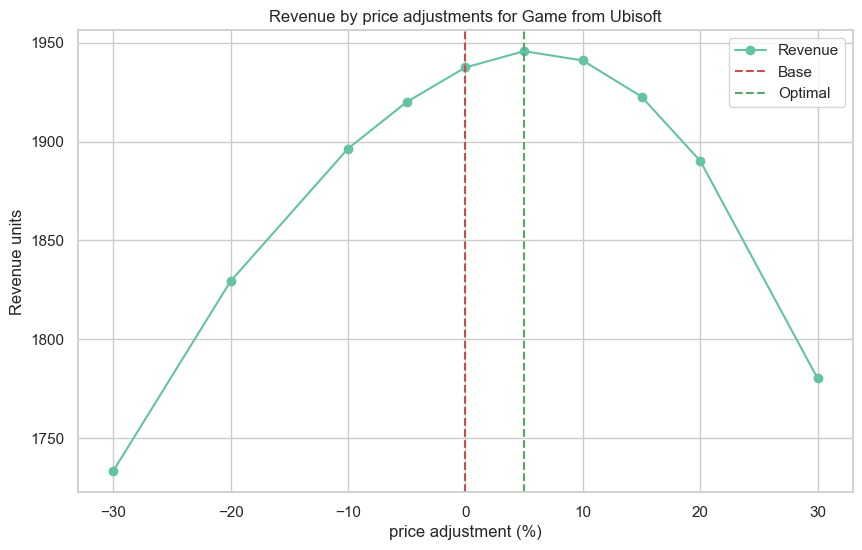


Game: Game from Indie Studio A
Publisher: Indie Studio A (Type: AAA)
Base predicted price: $16.11
Estimated elasticity: -1.20
optimal price adjustment: -10%
optimal price: $14.49
Revenue change vs base: 1.1%
Promotion discount: 9.2%
Sale price: $14.62


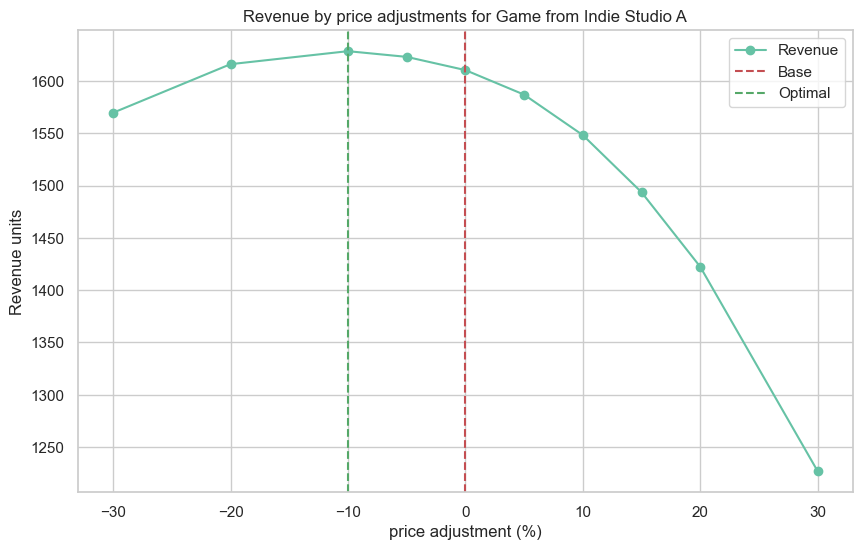


--- NEW GAME PRICE REPORT ---
Game: Stellar Conquest: Galaxy Wars
Genre: Strategy,Simulation
Publisher: Cosmic Games

PRICE PREDICTION REPORT:
  Base predicted price: $22.67
  Bucket: $20-$29.99
  Elasticity: -1.05

PRICING RECOMMENDATIONS:
  Optimal price: $22.67
  Adjustment from base: 0.0%
  Launch discount: 8.2%
  Sale price: $20.81

MARKET POSITIONING:
  Midrange tier

COMPARISON TO SIMILAR GAMES:
  Strategy type game $17.21 bucket $15-$19.99
  Simulation type game $19.21 bucket $15-$19.99

CONCLUSION:
  This title has moderate elasticity, standard pricing range recommended


In [4]:
best_model = load_model()
if best_model is not None:
    print(f"Model has {len(best_model['trees'])} trees and uses {len(best_model['feature_names'])} features")
    print(f"first five features: {best_model['feature_names'][:5]}")

    print("\n--- EXAMPLE 1 SINGLE GAME PREDICTION ---")
    gm1 = pd.DataFrame({
        'title': ['Epic Adventure'],
        'developers': ['Indie Game Studio'],
        'publishers': ['Indie Game Publishing'],
        'tags': ['Adventure,RPG,Open World,Story Rich'],
        'genres': ['Adventure,RPG'],
        'categories': ['Single-player,Steam Achievements'],
        'reviews_total': [5000],
        'achievements': [45],
        'combined_score': [0.85],
        'reviews_score_fancy': [92],
        'is_highly_rated': [1]
    })
    gm1f = engineer_features_for_prediction(gm1)
    predp = predict_price(gm1f, best_model)[0]
    print(f"Game: {gm1['title'][0]}")
    print(f"predicted price: {format_price(predp)}")
    print(f"price bucket: {create_price_bucket(predp)}")

    print("\n--- EXAMPLE 2 GENRE PRICE COMPARISON ---")
    gns = ['RPG','Action','Strategy','Simulation','Casual','Indie']
    gm2 = pd.DataFrame({
        'title': [f"{g} Game" for g in gns],
        'developers': ['Studio Games']*len(gns),
        'publishers': ['Game Publishing']*len(gns),
        'tags': [f"{g},Adventure" for g in gns],
        'genres': [g for g in gns],
        'categories': ['Single-player']*len(gns),
        'reviews_total': [3000]*len(gns),
        'achievements': [30]*len(gns),
        'combined_score': [0.75]*len(gns),
        'reviews_score_fancy': [80]*len(gns),
        'is_highly_rated': [0]*len(gns)
    })
    gm2f = engineer_features_for_prediction(gm2)
    gm2p = predict_price(gm2f, best_model)
    gm2res = pd.DataFrame({
        'Genre': gns,
        'Predicted Price': [format_price(p) for p in gm2p],
        'Price Value': gm2p,
        'Price Bucket': [create_price_bucket(p) for p in gm2p]
    })
    print(gm2res[['Genre','Predicted Price','Price Bucket']])
    plt.figure(figsize=(10,6))
    sns.barplot(x='Genre', y='Price Value', data=gm2res)
    plt.title('Predicted Price by Genre')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print("\n---- EXAMPLE 3 REVIEW SCORE IMPACT ---")
    scs = [30,50,70,80,90,95]
    gm3 = pd.DataFrame({
        'title': [f"Game with {s}% Rating" for s in scs],
        'developers': ['Score Studio']*len(scs),
        'publishers': ['Score Publishing']*len(scs),
        'tags': ['Adventure,RPG']*len(scs),
        'genres': ['Adventure']*len(scs),
        'categories': ['Single-player']*len(scs),
        'reviews_total': [2000]*len(scs),
        'achievements': [25]*len(scs),
        'combined_score': [s/100 for s in scs],
        'reviews_score_fancy': scs,
        'is_highly_rated': [1 if s>=80 else 0 for s in scs]
    })
    gm3f = engineer_features_for_prediction(gm3)
    gm3p = predict_price(gm3f, best_model)
    gm3res = pd.DataFrame({
        'Review Score': scs,
        'Predicted Price': [format_price(p) for p in gm3p],
        'Price Value': gm3p
    })
    print(gm3res[['Review Score','Predicted Price']])
    plt.figure(figsize=(10,6))
    sns.lineplot(x='Review Score', y='Price Value', data=gm3res, marker='o')
    plt.title('Predicted Price by Review Score')
    plt.xlabel('Review Score (%)')
    plt.ylabel('Price ($)')
    plt.grid(True)
    plt.show()

    print("\n----- EXAMPLE 4 AAA VS INDIE PUBLISHER ----")
    pubs = [
        'Ubisoft','Electronic Arts','Activision Blizzard',
        'Indie Studio A','Small Developer B','Solo Developer C'
    ]
    isaaa = [1,1,1,0,0,0]
    gm4 = pd.DataFrame({
        'title': [f"Game from {pb}" for pb in pubs],
        'developers': pubs,
        'publishers': pubs,
        'tags': ['Adventure,Action']*len(pubs),
        'genres': ['Action']*len(pubs),
        'categories': ['Single-player,Multi-player']*len(pubs),
        'reviews_total': [10000,12000,15000,2000,1500,500],
        'achievements': [50,60,70,30,25,15],
        'combined_score': [0.8,0.85,0.9,0.75,0.7,0.6],
        'reviews_score_fancy': [85,90,92,80,75,65],
        'is_highly_rated': [1,1,1,1,0,0]
    })
    gm4f = engineer_features_for_prediction(gm4)
    gm4f['publishers_is_aaa'] = isaaa
    gm4p = predict_price(gm4f, best_model)
    elas = [estimate_elasticity(gm4f.iloc[i]) for i in range(len(gm4f))]
    disc = [recommend_discount(gm4f.iloc[i]) for i in range(len(gm4f))]
    gm4res = pd.DataFrame({
        'Publisher': pubs,
        'Type': ['AAA' if f==1 else 'Indie' for f in isaaa],
        'Predicted Price': [format_price(pp) for pp in gm4p],
        'Price Value': gm4p,
        'Elasticity': elas,
        'Recommended Discount': [f"{d:.1f}%" for d in disc]
    })
    print(gm4res[['Publisher','Type','Predicted Price','Elasticity','Recommended Discount']])
    plt.figure(figsize=(10,6))
    ax = sns.barplot(x='Publisher', y='Price Value', hue='Type', data=gm4res)
    plt.title('Predicted Price by Publisher Type')
    plt.ylabel('Price ($)')
    plt.xticks(rotation=45)
    for i, p in enumerate(ax.patches):
        ax.annotate(format_price(p.get_height()),
            (p.get_x()+p.get_width()/2., p.get_height()),
            ha='center', va='bottom',
            xytext=(0,5), textcoords='offset points')
    plt.tight_layout()
    plt.show()

    print("\n--- EXAMPLE 5 OPTIMAL PRICING STRATEGY ---")
    adjlist = [-30,-20,-10,-5,0,5,10,15,20,30]
    selgms = gm4.iloc[[0,3]]
    selgfeat = gm4f.iloc[[0,3]]
    selgprice = gm4p[[0,3]]
    selgelas = [elas[0], elas[3]]
    for idx,(_, gam) in enumerate(selgms.iterrows()):
        print(f"\nGame: {gam['title']}")
        print(f"Publisher: {gam['publishers']} (Type: {gm4res['Type'][idx]})")
        print(f"Base predicted price: {format_price(selgprice[idx])}")
        print(f"Estimated elasticity: {selgelas[idx]:.2f}")
        revs = []
        for adp in adjlist:
            newp = selgprice[idx]*(1+adp/100)
            pch = adp/100
            if pch>=0:
                qtyc = pch*selgelas[idx]*(1+0.5*pch)
            else:
                qtyc = pch*selgelas[idx]*(1-0.3*pch)
            newq = 100*(1+qtyc)
            newq = max(0,newq)
            revs.append(newp*newq)
        besti = revs.index(max(revs))
        bestadj = adjlist[besti]
        bestp = selgprice[idx]*(1+bestadj/100)
        basei = adjlist.index(0)
        print(f"optimal price adjustment: {bestadj:+}%")
        print(f"optimal price: {format_price(bestp)}")
        print(f"Revenue change vs base: {revs[besti]/revs[basei]-1:.1%}")
        drec = recommend_discount(selgfeat.iloc[idx])
        salep = selgprice[idx]*(1-drec/100)
        print(f"Promotion discount: {drec:.1f}%")
        print(f"Sale price: {format_price(salep)}")
        plt.figure(figsize=(10,6))
        plt.plot(adjlist, revs, 'o-', label='Revenue')
        plt.axvline(x=0, color='r', linestyle='--', label='Base')
        plt.axvline(x=bestadj, color='g', linestyle='--', label='Optimal')
        plt.title(f"Revenue by price adjustments for {gam['title']}")
        plt.xlabel('price adjustment (%)')
        plt.ylabel('Revenue units')
        plt.grid(True)
        plt.legend()
        plt.show()

    print("\n--- NEW GAME PRICE REPORT ---")
    newg = pd.DataFrame({
        # This is a fake game for our demo, in our Streamlit
        # the user would pick a game from database or input a new one
        'title': ['Stellar Conquest: Galaxy Wars'],
        'developers': ['Cosmic Studio'],
        'publishers': ['Cosmic Games'],
        'tags': ['Strategy,Sci-Fi,Space,Multiplayer,RTS'],
        'genres': ['Strategy,Simulation'],
        'categories': ['Single-player,Multi-player,Steam Achievements,Steam Workshop'],
        'reviews_total': [7500],
        'achievements': [65],
        'combined_score': [0.82],
        'reviews_score_fancy': [87],
        'is_highly_rated': [1]
    })
    newgf = engineer_features_for_prediction(newg)
    newgp = predict_price(newgf, best_model)[0]
    newgelast = estimate_elasticity(newgf.iloc[0])
    newgdisc = recommend_discount(newgf.iloc[0])
    newgopt = suggest_optimal_price(newgf.iloc[0], newgp, newgelast)
    salep = newgp*(1-newgdisc/100)

    print(f"Game: {newg['title'][0]}")
    print(f"Genre: {newg['genres'][0]}")
    print(f"Publisher: {newg['publishers'][0]}")
    print("\nPRICE PREDICTION REPORT:")
    print(f"  Base predicted price: {format_price(newgp)}")
    print(f"  Bucket: {create_price_bucket(newgp)}")
    print(f"  Elasticity: {newgelast:.2f}")
    print("\nPRICING RECOMMENDATIONS:")
    print(f"  Optimal price: {format_price(newgopt)}")
    print(f"  Adjustment from base: {(newgopt/newgp - 1):.1%}")
    print(f"  Launch discount: {newgdisc:.1f}%")
    print(f"  Sale price: {format_price(salep)}")
    print("\nMARKET POSITIONING:")
    if newgp>29.99:
        print("  Premium tier")
    elif newgp>14.99:
        print("  Midrange tier")
    else:
        print("  Budget tier")
    print("\nCOMPARISON TO SIMILAR GAMES:")
    simg = gm2res[gm2res['Genre'].isin(['Strategy','Simulation'])]
    for _,rw in simg.iterrows():
        print(f"  {rw['Genre']} type game {rw['Predicted Price']} bucket {rw['Price Bucket']}")
    print("\nCONCLUSION:")
    if newgelast > -1.0:
        print("  This title has inelastic demand ,can support a premium price range")
    elif newgelast > -2.0:
        print("  This title has moderate elasticity, standard pricing range recommended")
    else:
        print("  This title has high elasticity lower pricing can help revenue")
else:
    print("no model loaded, please verify path or file")